# P300 Speller Dataset - BCI Competition III

## Dataset Overview

This dataset comes from the **BCI Competition III Challenge** (2004) by Dean Krusienski and Gerwin Schalk from the Wadsworth Center/NYSDOH. It contains P300 event-related potential (ERP) data collected during a P300 speller paradigm.

## What is P300?

The **P300** is a positive-going ERP component that occurs approximately 300ms after a rare, task-relevant stimulus. It's particularly strong when subjects attend to infrequent "target" stimuli among frequent "non-target" stimuli. This makes it useful for Brain-Computer Interface (BCI) applications like spelling devices.

## Experimental Paradigm: P300 Speller

### The Task
- **6×6 character matrix**: Contains letters A-Z, numbers 1-9, and underscore (_)
- **Row/Column Flashing**: Rows and columns flash randomly and rapidly
- **Subject Task**: Count how many times the row and column containing their target character flash
- **Target Detection**: The P300 response is strongest when the target character's row or column flashes

### Data Collection Setup
- **64 EEG electrodes** positioned according to the 10-20 system
- **Sampling rate**: 240 Hz (240 samples per second)
- **Analysis window**: 1 second (240 samples) after each stimulus
- **Key electrode**: Cz (central midline) - channel 11 in the data

## Data Structure

### Files Available
- `Subject_A_Train.mat` - Training data for Subject A
- `Subject_A_Test.mat` - Test data for Subject A  
- `Subject_B_Train.mat` - Training data for Subject B
- `Subject_B_Test.mat` - Test data for Subject B
- `eloc64.txt` - 64-channel electrode positions and names

### Data Variables (in .mat files)
- **Signal**: EEG data [epochs × samples × channels]
- **Flashing**: Binary indicator of when stimuli occurred [epochs × samples]
- **StimulusCode**: Which row/column (1-12) was flashing [epochs × samples]
- **StimulusType**: Whether it was a target (1) or non-target (0) [epochs × samples]

### Electrode Layout
The `eloc64.txt` file contains 64 electrode positions:
- **Frontal**: Fp1, Fpz, Fp2, Af7, Af3, Afz, Af4, Af8
- **Central**: Fz, Cz, Pz (key for P300 detection)
- **Temporal**: T7, T8, T9, T10
- **Parietal**: P1, P2, P3, P4, P5, P6, P7, P8, Pz
- **Occipital**: O1, Oz, O2, Iz

## Classification Approach

The example code shows a simple P300 detection method:
1. **Extract responses** around each flash (240ms window)
2. **Average responses** for each row/column
3. **Calculate scores** using peak detection around 300ms
4. **Classify characters** by finding the row-column intersection with highest score

## Key Parameters
- **Analysis window**: 240 samples (1 second at 240 Hz)
- **P300 peak window**: Samples 54-124 (225-516ms)
- **Baseline window**: Samples 134-174 (558-725ms)
- **Primary electrode**: Cz (channel 11)

In [167]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy import signal
import pandas as pd

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)


In [168]:
# Load Subject A's training data
# The .mat file stores info from a P300 speller experiment.
# It includes EEG signals and timing info for when letters flashed.

data_path = 'BCI_Comp_III_Wads_2004/Subject_A_Train.mat'
data = scipy.io.loadmat(data_path)

# Pull out the key variables from the file
Signal = data['Signal']          # The EEG data (microvolts) recorded from each electrode
Flashing = data['Flashing']      # 1 when a letter/row/column is flashing, 0 otherwise
StimulusCode = data['StimulusCode']  # Which row or column is flashing (numbers 1–12)
StimulusType = data['StimulusType']  # 1 if that flash was part of the target letter

# Just checking what the shapes look like
# Signal has 3D shape: (epochs, time points, channels)
# The others have 2D shape: (epochs, time points)
print("Data shapes:")
print(f"Signal: {Signal.shape}")
print(f"Flashing: {Flashing.shape}")
print(f"StimulusCode: {StimulusCode.shape}")
print(f"StimulusType: {StimulusType.shape}")

# Convert everything to floating-point numbers (decimals)
# MATLAB uses doubles by default, so this avoids weird math issues with integers
Signal = Signal.astype(np.float64)
Flashing = Flashing.astype(np.float64)
StimulusCode = StimulusCode.astype(np.float64)
StimulusType = StimulusType.astype(np.float64)

Data shapes:
Signal: (85, 7794, 64)
Flashing: (85, 7794)
StimulusCode: (85, 7794)
StimulusType: (85, 7794)


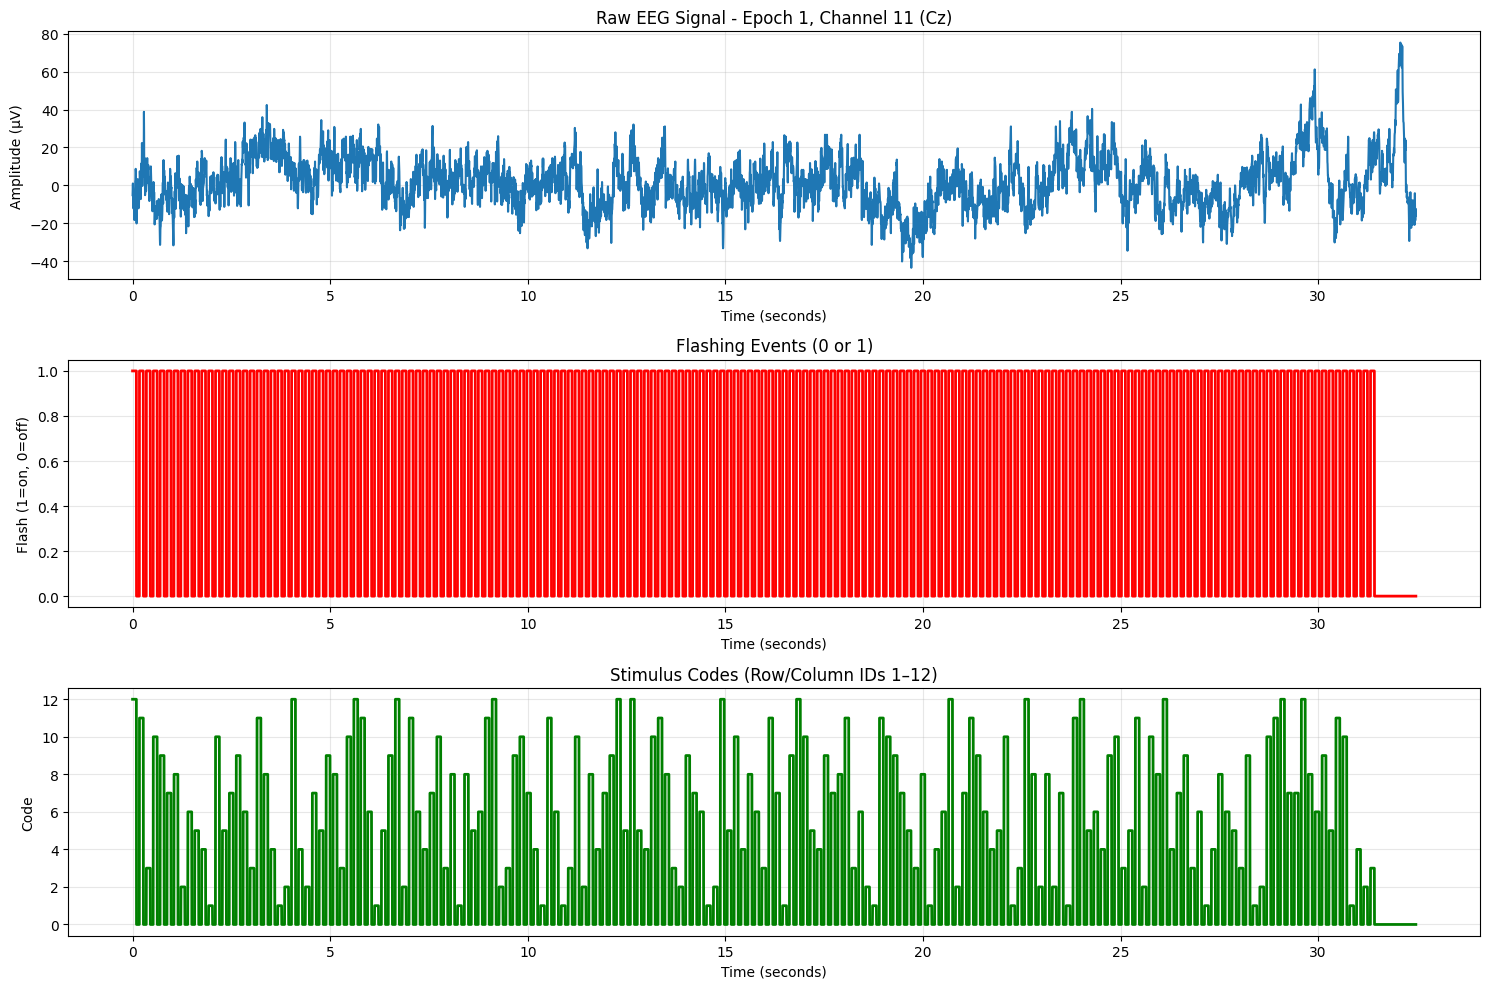

In [169]:
# Look at what the raw EEG signal actually looks like
# Each “epoch” is basically one trial (the subject focuses on one letter)

epoch = 0        # Use the first trial (out of 85 total)
channel = 10     # Channel 10 = Cz electrode (in MATLAB this would be channel 11)

# Create a time axis (sampling rate is 240 Hz)
# This turns the sample numbers (0–7793) into seconds
time = np.arange(Signal.shape[1]) / 240.0

plt.figure(figsize=(15, 10))

# --- Plot 1: Raw EEG signal ---
# Shows the actual brainwave voltage (in microvolts)
# The P300 spike won’t stand out here yet — it’s buried in noise until we average multiple trials
plt.subplot(3, 1, 1)
plt.plot(time, Signal[epoch, :, channel])
plt.title(f'Raw EEG Signal - Epoch {epoch+1}, Channel {channel+1} (Cz)')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (μV)')
plt.grid(True, alpha=0.3)

# --- Plot 2: Flashing timeline ---
# Shows when the screen flashed during the trial (1 = flash, 0 = no flash)
# Each “flash” is a visual event the subject saw — we’ll later align EEG data to these times
plt.subplot(3, 1, 2)
plt.plot(time, Flashing[epoch, :], 'r-', linewidth=2)
plt.title('Flashing Events (0 or 1)')
plt.xlabel('Time (seconds)')
plt.ylabel('Flash (1=on, 0=off)')
plt.grid(True, alpha=0.3)

# --- Plot 3: Stimulus codes ---
# Tells which row or column flashed at each moment
# Codes 1–6 are rows, 7–12 are columns
# These will let us figure out *which* letter was being shown
plt.subplot(3, 1, 3)
plt.plot(time, StimulusCode[epoch, :], 'g-', linewidth=2)
plt.title('Stimulus Codes (Row/Column IDs 1–12)')
plt.xlabel('Time (seconds)')
plt.ylabel('Code')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
